In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Predicting Price Movements of Cryptocurrencies - Using Convolutional Neural Networks to Classify 2D Images of Chart Data

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# For downloading files
from IPython.display import FileLink, FileLinks

In [2]:
PATH = 'data/btc-trading-patterns/'
!ls {PATH}

models	test  tmp  train


In [3]:
os.listdir(f'{PATH}train')

['2', '9', '4', '1', '6', '5', '7', '8', '3', '0']

In [4]:
files = os.listdir(f'{PATH}train/0')[:5]
files

['a1335c4e-9f4d-435b-93f7-6f09d56338fc.png',
 '37dc33ee-5cd9-470e-a3b1-8da720f1075a.png',
 'c5cbabcb-1708-4c75-8099-feb958d0d024.png',
 'fdeee572-5867-4f46-9fcf-92529d034e6c.png',
 '1952cb83-60a6-46a3-8c00-51249063b8bf.png']

data/btc-trading-patterns/train/0/a1335c4e-9f4d-435b-93f7-6f09d56338fc.png
data/btc-trading-patterns/train/0/37dc33ee-5cd9-470e-a3b1-8da720f1075a.png


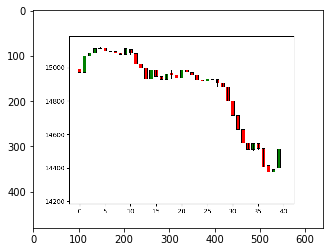

In [5]:
img = plt.imread(f'{PATH}train/0/{files[0]}')
print(f'{PATH}train/0/{files[0]}')
print(f'{PATH}train/0/{files[1]}')
plt.imshow(img)

# The Steps to Follow
1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## 0. Setup

In [6]:
arch = resnet34
sz = 299
bsz = int(64/2)

## 1. Data Augmentation
**Not using data augmentation this time**

Starting without useing data augmentation because I don't think it makes sense for these graphs, we don't need to generalize to slightly different angles. All plots will always be straight on and square in the frame.

In [7]:
tfms = tfms_from_model(arch, sz)

In [8]:
data = ImageClassifierData.from_paths(PATH, bs=bsz, tfms=tfms, 
                                      trn_name='train', val_name='test')

## 2. Choose a Learning Rate

In [9]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [10]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 73%|███████▎  | 20550/28125 [07:48<02:52, 43.87it/s, loss=9.07]

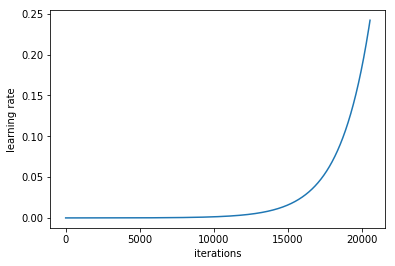

In [11]:
learn.sched.plot_lr()

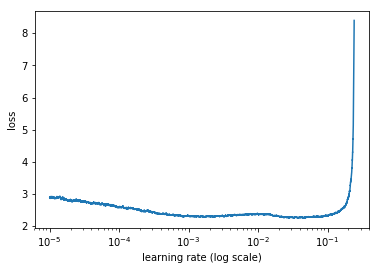

 73%|███████▎  | 20550/28125 [08:00<02:57, 42.77it/s, loss=9.07]

In [12]:
learn.sched.plot()

In [13]:
learn.fit(1e-4, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  2%|▏         | 499/28125 [00:04<04:35, 100.25it/s, loss=2.72]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/liam/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/liam/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/liam/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                       
    0      2.272055   2.238607   0.1571    
    1      2.255451   2.230383   0.16278                         
    2      2.254322   2.22675    0.16428                         



[2.22675, 0.16428]

# Look at Results

In [14]:
data.val_y

array([0, 0, 0, ..., 9, 9, 9])

In [15]:
data.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [18]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(100000, 10)

In [19]:
log_preds[:10]

array([[-1.72575, -2.10038, -2.59658, -2.71269, -2.71123, -2.79055, -2.78275, -2.4826 , -2.10304, -1.81189],
       [-1.5613 , -2.2999 , -2.52787, -2.83588, -3.35044, -3.06732, -2.78733, -2.59232, -2.19467, -1.50539],
       [-1.74429, -2.1479 , -2.47271, -2.74819, -3.07946, -2.96243, -2.64585, -2.3249 , -2.11485, -1.75426],
       [-2.84343, -2.81333, -2.50111, -2.39041, -1.44048, -2.03514, -2.28319, -2.45505, -2.40818, -2.76604],
       [-1.72021, -2.20085, -2.54052, -2.76717, -2.60804, -2.72174, -2.8697 , -2.4542 , -2.07112, -1.82967],
       [-1.72205, -2.25266, -2.62482, -2.62022, -2.95059, -2.91642, -2.69897, -2.45141, -2.0657 , -1.69103],
       [-1.66886, -2.15288, -2.53902, -2.77013, -3.1737 , -3.01693, -2.79512, -2.56833, -2.1724 , -1.55439],
       [-2.12103, -2.34557, -2.29627, -2.29025, -2.59302, -2.45378, -2.33977, -2.45112, -2.16587, -2.08372],
       [-2.91521, -2.39598, -2.32921, -2.22193, -1.86952, -2.12501, -2.19809, -2.17383, -2.29775, -2.99408],
       [-2.03088, -

In [20]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
probs

array([0.12241, 0.10027, 0.11673, ..., 0.10382, 0.10933, 0.11614], dtype=float32)

In [22]:
probs[1]

0.1002687

In [23]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y)==is_correct)
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


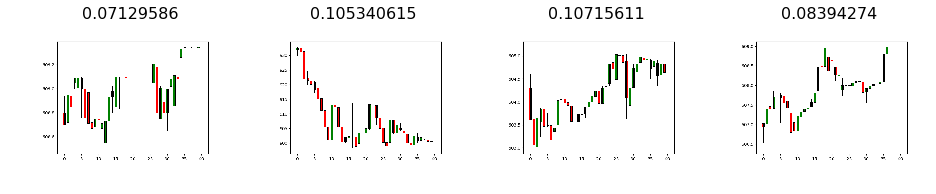

In [24]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [25]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct 0


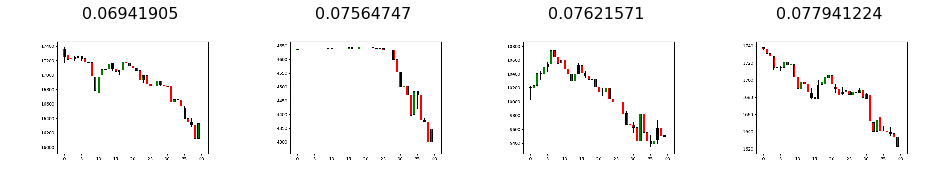

In [27]:
plot_val_with_title(most_by_correct(0, True), "Most correct 0")

Most correct 1


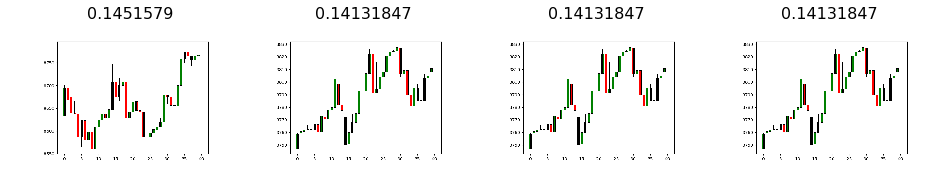

In [28]:
plot_val_with_title(most_by_correct(1, True), "Most correct 1")

Most correct 2


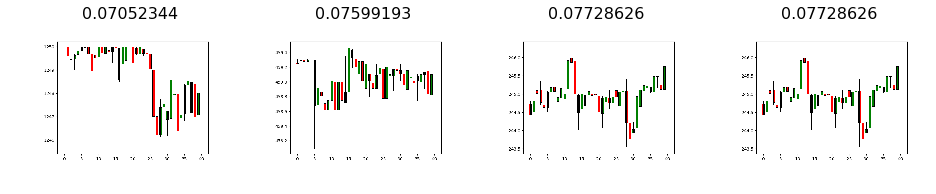

In [29]:
plot_val_with_title(most_by_correct(2, True), "Most correct 2")

Most correct 3


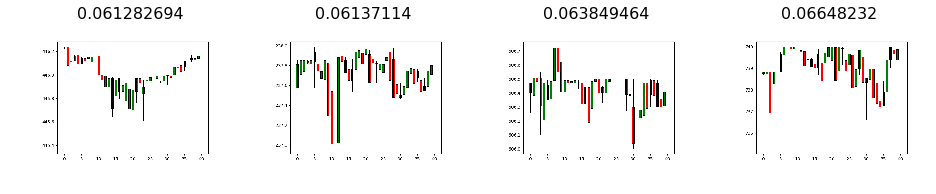

In [30]:
plot_val_with_title(most_by_correct(3, True), "Most correct 3")

Most correct 4


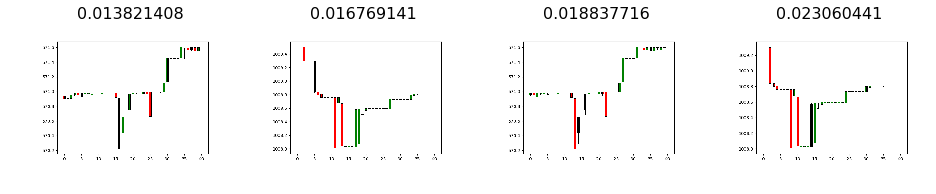

In [31]:
plot_val_with_title(most_by_correct(4, True), "Most correct 4")